In [ ]:
from scipy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
import copy
import numpy as np
import pywt
from pandas import read_csv

In [ ]:

# Функция для считывания ксв
def csv(path):
    # Сначала списком сохраняем Х, а затем y
    return list(read_csv(path, names = ['x','y'])['x']), list(read_csv(path, names = ['x','y'])['y'])

# Давайте взглянем на сами графики...

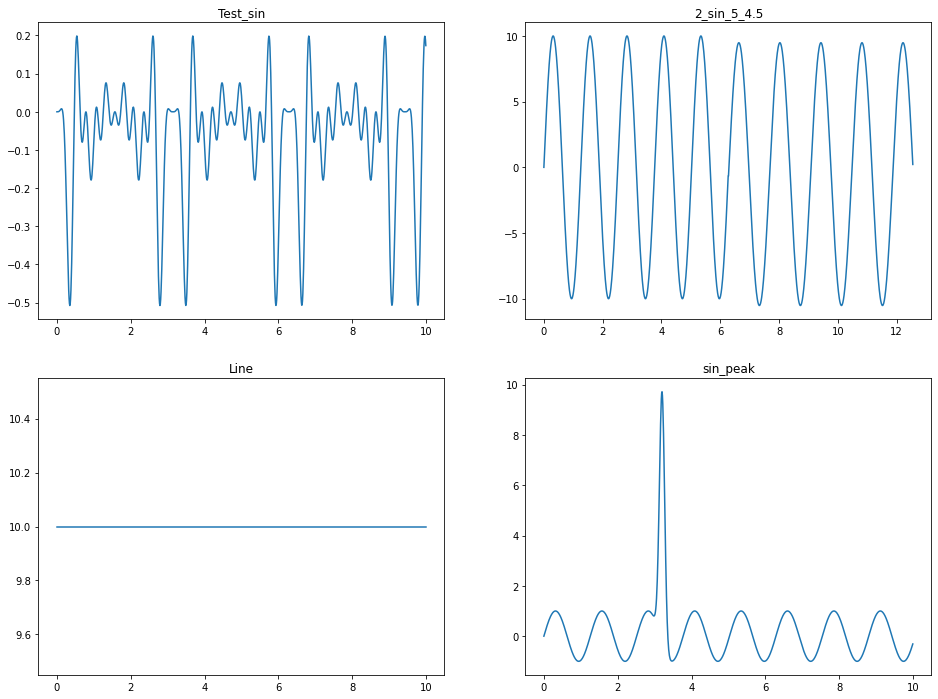

In [ ]:
fig, axes = plt.subplots(2, 2)
x, y = csv('Test_sin.csv')
axes[0][0].plot(x, y)
axes[0][0].set(title = 'Test_sin')
x, y = csv('2_sin_5_4.5.csv')
axes[0][1].plot(x, y)
axes[0][1].set(title = '2_sin_5_4.5')
x, y = csv('Line.csv')
axes[1][0].plot(x, y)
axes[1][0].set(title = 'Line')
x, y = csv('sin_peak.csv')
axes[1][1].plot(x, y) 
axes[1][1].set(title = 'sin_peak')

fig.set_figwidth(16)
fig.set_figheight(12)

# Разберемся с АЧХ

In [ ]:
def disp(signal, cur_ans):

    signal = signal.copy()
    #print(len(signal), len(cur_ans))
    return ((sum([(signal[i] - cur_ans[i])**2 for i in range(len(signal))]))/len(signal))**0.5

Будем работать с библиотекой scipy для быстрого преобразования Фурье

In [ ]:
def AFR(f_name):
    X, signal = csv(f_name)
    X_start = X.copy()
    plt.figure(figsize = (30, 10))
    plt.subplot(1, 3, 1)

    plt.plot(X, signal)
    plt.title('Исходная функция')

    
#     Для правильного отображения АЧХ, нам необходимо найти период
    period = (len(X))/(X[-1] - X[0])
#     Далее расчитаем АЧХ, с помощью библиотеки scipy
    X = rfftfreq(len(signal), 1 / period) # Здесь 1/period - частота
    Y = [el for el in rfft(signal)]
    #Y = [abs(el) for el in rfft(signal)] # Просто из документации как-то так надо писать
#     Далее строим графики

    

    plt.subplot(1, 3, 2)
    plt.plot(X, np.abs(Y))
    plt.title('Спектрограмма')

    plt.subplot(1, 3, 3)
    y_new = irfft(Y)
    plt.plot(X_start, y_new)
#     Теперь рассчитаем коэффициент несинусоидальности 
#     Для этого посчитаем площадь гармоники с максимальной амплитудой,
#     затем посчитаем все и вычтем из них максимальное, далее возьмем отношение
#     этих двух величин
    step = X[1] - X[0]
#     Далее найдем максимальный и вычислим площадь 
    s0 = ((Y[Y.index(max(Y)) + 1] + Y[Y.index(max(Y)) + 1])/2 + Y[Y.index(max(Y))])*step
    si = 0
    for i in range(1, len(Y)):
        si += (Y[i-1] + Y[i])* step/2

    print(f'Название файла: {f_name}')
    print(f'Коэффициент несиносоидальности = {(si-s0)/s0}')
    print(f'Дисперсия = {disp(y, y_new)}')
    


Название файла: 2_sin_5_4.5.csv
Коэффициент несиносоидальности = (-1.0455344275146075-1.9502417637752765j)
Дисперсия = 6.600114089032796


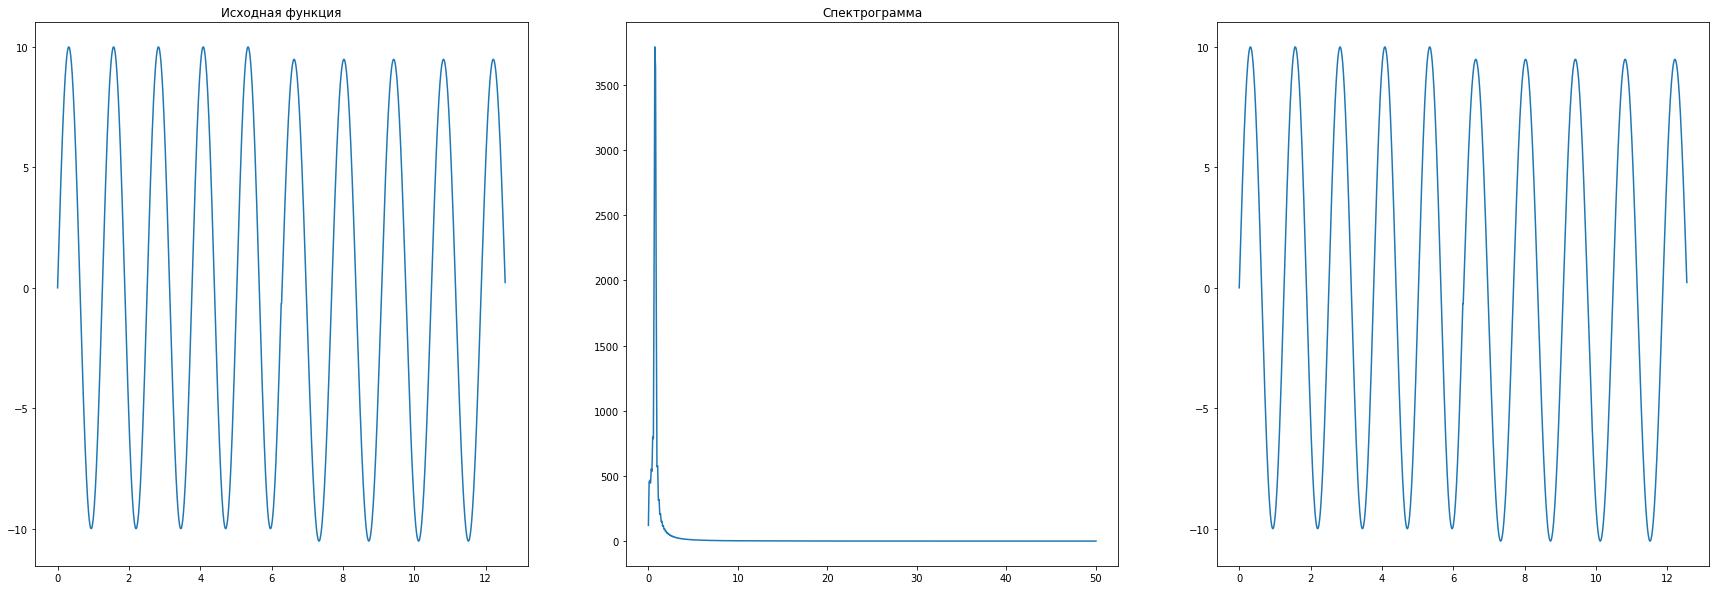

In [ ]:
AFR('2_sin_5_4.5.csv')

Название файла: Test_sin.csv
Коэффициент несиносоидальности = (-1.2611813033838075+0.8309812890584188j)
Дисперсия = 1.300334497898656


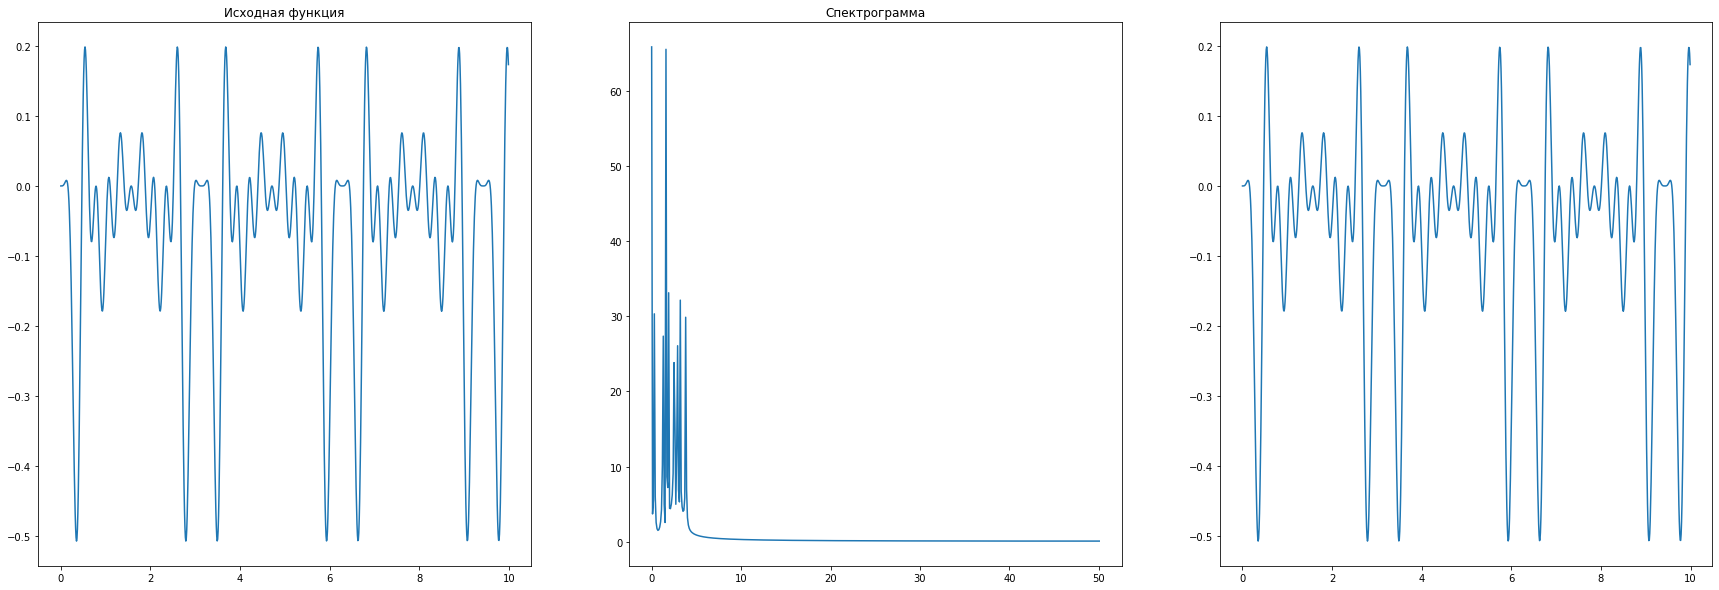

In [ ]:
AFR('Test_sin.csv')

Название файла: Line.csv
Коэффициент несиносоидальности = (-0.5-3.760339415513936e-17j)
Дисперсия = 9.904463220872028


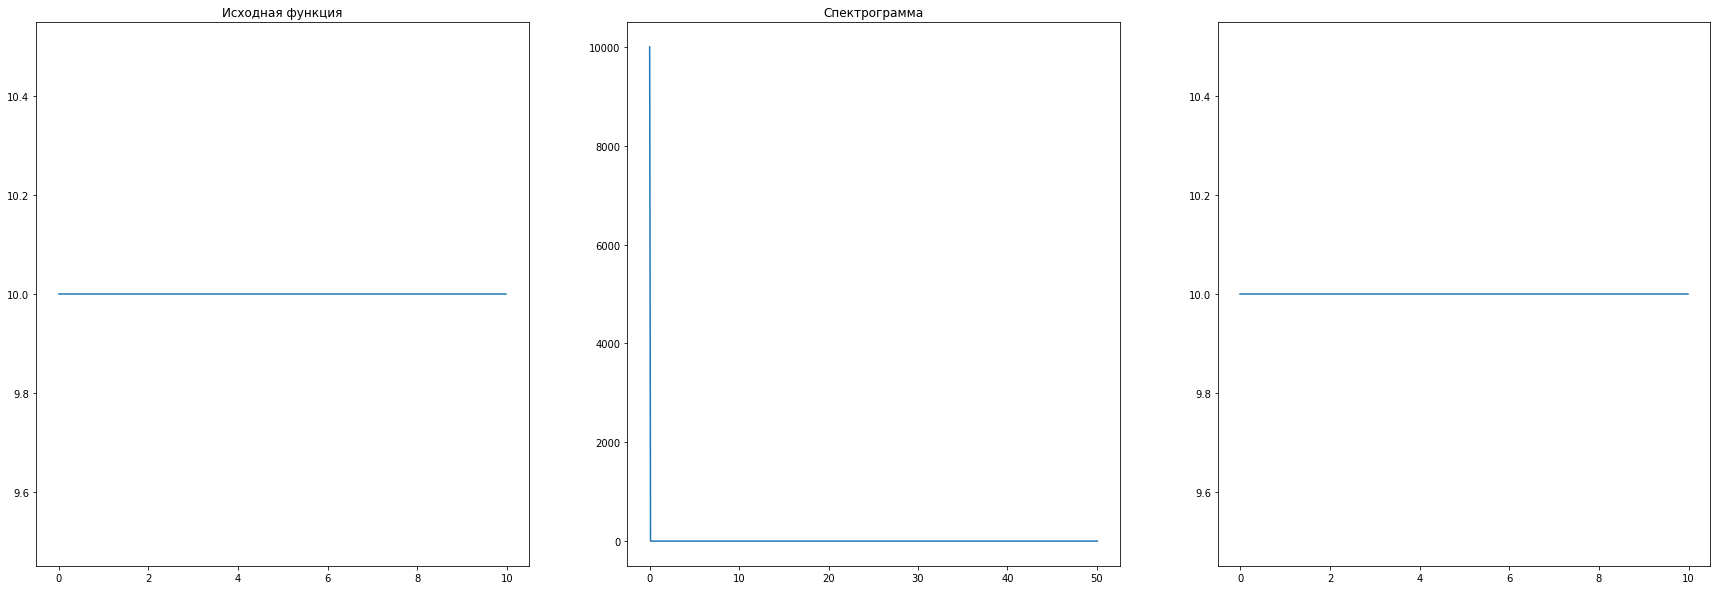

In [ ]:
AFR('Line.csv')

# Далее Вейвлеты

In [ ]:
def mean(a):
    return sum(a)/len(a)

In [ ]:
def wavelet_dis(signal, name, vis = True):
    if vis:
        #print('тип:', name)
        plt.figure(figsize = (10, 10))

        for i in range(4):
            coeff = pywt.wavedec(signal, name, level= i)
            plt.subplot(5, 1, i + 1)
            plt.plot(coeff[0], label = f'level {i + 1}')
            plt.legend()
        plt.subplot(5, 1, 5)
        plt.plot(signal, label = f'signal')
        plt.legend()
        plt.show()

    return pywt.wavedec(signal, name, level= 3)[0]

In [ ]:
def wavelet_cont(signal, name, vis = True):
    coef, freqs = pywt.cwt(signal, np.arange(1, 30), name)
    if (vis):
        print('тип:', name)
        plt.figure(figsize = (10, 10))

        for i in range(4):
            plt.subplot(5, 1, i + 1)
            plt.plot(coef[i], label = f'level {i + 1}')
            plt.legend()
        plt.subplot(5, 1, 5)
        plt.plot(signal, label = f'signal')
        plt.legend()

    return coef[4]

In [ ]:
def work_with_signal(file_name: str):
    plt.figure(figsize = (10, 10))
    x, y = csv(file_name)
    plt.plot(x, y)
    step = x[1] - x[0]
    d = {}
    types_dis = ['db2', 'haar']
    types_cont = ['mexh', 'gaus1']
    plt.subplot(len(types_dis) + len(types_cont) + 1, 1, 1)
    cnt = 2
    plt.plot(y)
    plt.ylabel('signal')
    for el in types_dis:
        d[el] = wavelet_dis(y, el, 0)
        plt.subplot(len(types_dis) + len(types_cont) + 1, 1, cnt)
        plt.plot(d[el])
        cnt += 1
        plt.ylabel(el)

    
    for el in types_cont:
        d[el] = wavelet_cont(y, el, 0)
        plt.subplot(len(types_dis) + len(types_cont) + 1, 1, cnt)
        plt.plot(d[el])
        cnt += 1
        plt.ylabel(el)

    d = dict(sorted(d.items(), key=lambda x: disp(y, x[1])))
    #print(d)
    print(f'best opyion for data from {file_name} is {list(d)[0]}')

db2


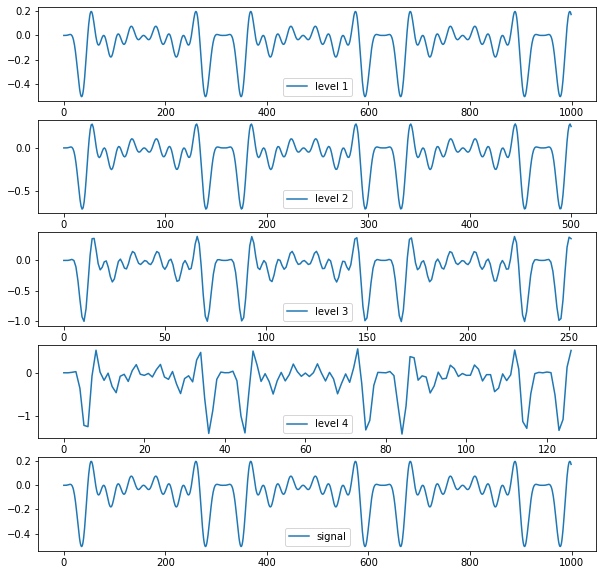

In [ ]:
x, y = csv('Test_sin.csv')

print('db2')
t = wavelet_dis(y, 'db2', 1)


db2


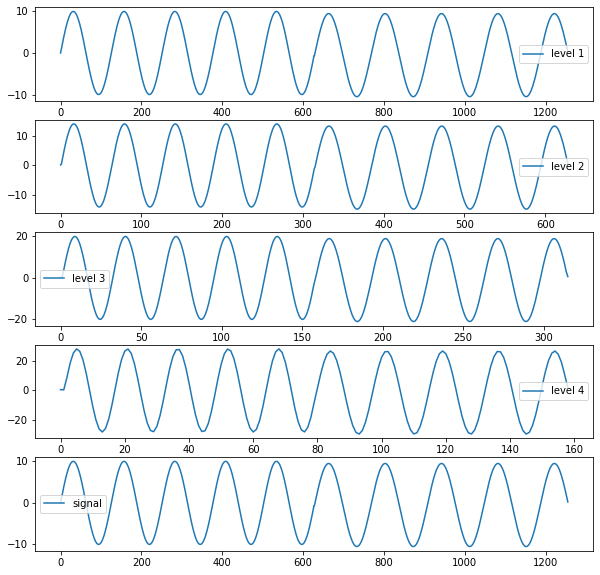

In [ ]:
x, y = csv('2_sin_5_4.5.csv')

print('db2')
t = wavelet_dis(y, 'db2', 1)


haar


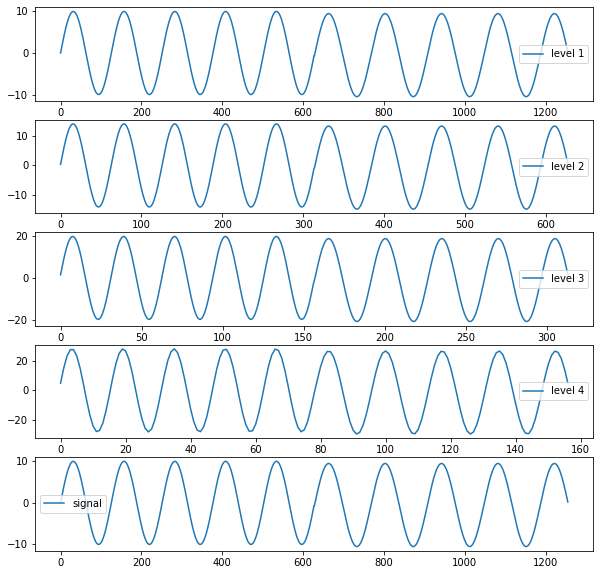

In [ ]:
print('haar')
t = wavelet_dis(y, 'haar', 1)

db2


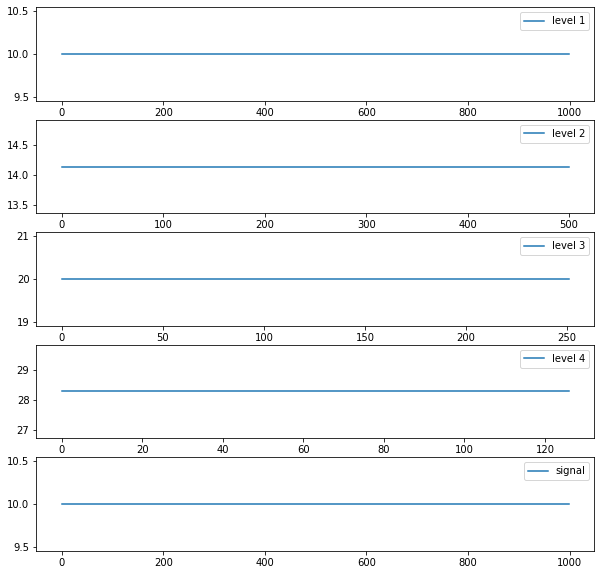

In [ ]:
x, y = csv('Line.csv')

print('db2')
t = wavelet_dis(y, 'db2', 1)

haar


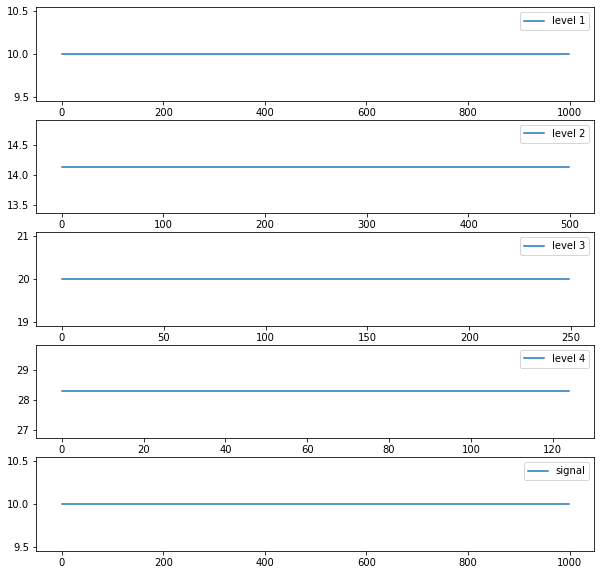

In [ ]:
print('haar')
t = wavelet_dis(y, 'haar', 1)


тип: gaus1


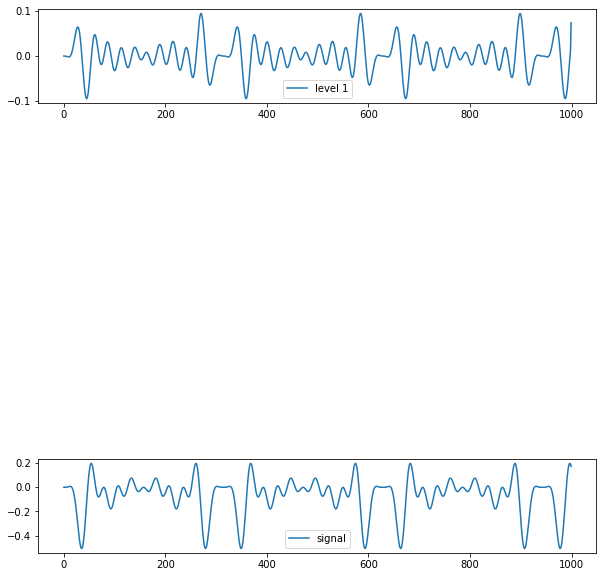

In [ ]:
types_cont = ['mexh', 'gaus1']
name = 'gaus1'
vis = 1
file_name = 'Test_sin.csv'
x, y = csv(file_name)
signal = y
coef, freqs = pywt.cwt(signal, np.arange(1, 20), name)
if (vis):
    print('тип:', name)
    plt.figure(figsize = (10, 10))

    for i in range(1):
        plt.subplot(5, 1, i + 1)
        plt.plot(coef[i], label = f'level {i + 1}')
        plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(signal, label = f'signal')
    plt.legend()


In [ ]:
coef[0]

array([-6.85117145e-07, -8.07065091e-06, -4.33729918e-05, -1.39029711e-04,
       -3.21644283e-04, -6.00688616e-04, -9.63027884e-04, -1.37001914e-03,
       -1.75696786e-03, -2.03508014e-03, -2.09588858e-03, -1.81794808e-03,
       -1.07542541e-03,  2.51944404e-04,  2.26818177e-03,  5.05039336e-03,
        8.63887142e-03,  1.30287088e-02,  1.81636130e-02,  2.39324943e-02,
        3.01692491e-02,  3.66559834e-02,  4.31297086e-02,  4.92923368e-02,
        5.48235831e-02,  5.93961935e-02,  6.26927461e-02,  6.44231470e-02,
        6.43418596e-02,  6.22638807e-02,  5.80785052e-02,  5.17600081e-02,
        4.33745089e-02,  3.30824724e-02,  2.11365183e-02,  7.87445920e-03,
       -6.29225229e-03, -2.08942360e-02, -3.54233828e-02, -4.93546601e-02,
       -6.21694832e-02, -7.33794965e-02, -8.25495633e-02, -8.93187724e-02,
       -9.34183514e-02, -9.46855144e-02, -9.30724675e-02, -8.86500347e-02,
       -8.16056367e-02, -7.22356473e-02, -6.09324437e-02, -4.81667434e-02,
       -3.44660748e-02, -

In [ ]:
(freqs)


array([0.2       , 0.1       , 0.06666667, 0.05      , 0.04      ,
       0.03333333, 0.02857143, 0.025     , 0.02222222, 0.02      ,
       0.01818182, 0.01666667, 0.01538462, 0.01428571, 0.01333333,
       0.0125    , 0.01176471, 0.01111111, 0.01052632, 0.01      ,
       0.00952381, 0.00909091, 0.00869565, 0.00833333, 0.008     ,
       0.00769231, 0.00740741, 0.00714286, 0.00689655])